In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import cross_val_score, train_test_split, GridSearchCV
from sklearn.ensemble import RandomForestRegressor, RandomForestClassifier
from sklearn.metrics import confusion_matrix, accuracy_score, mean_squared_error, r2_score, f1_score
from rfpimp import permutation_importances

from collections import OrderedDict
from sklearn.datasets import make_classification
from sklearn.linear_model import LogisticRegression

import logistic_regression_functions as lrf
import GradientDescent as GD
GradientDescent = GD.GradientDescent

In [2]:
import statsmodels.api as sm
import statsmodels.formula.api as smf

import plotly.plotly as py
from plotly.graph_objs import *
from sklearn.preprocessing import scale
from statsmodels.stats.outliers_influence import variance_inflation_factor

In [3]:
from process_players import *

In [4]:
a = get_clean_pdata()

In [6]:
a.head(2)

,Player,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,WS,WS/48,OBPM,DBPM,BPM,VORP,TM,YR,YRprior,MPG
1933,Allen Iverson,SG,32,82,3424,20.9,0.567,0.177,0.512,1.5,...,11.6,0.163,3.5,-1.9,1.6,3.1,Denver Nuggets 07-08,8,7,41.756098
2344,Gilbert Arenas,PG,24,80,3384,23.8,0.581,0.324,0.479,2.0,...,13.6,0.193,6.9,-1.4,5.5,6.4,Washington Wizards 05-06,6,5,42.300000


In [7]:
tracking = pd.read_csv('data/Pstats - tracking.csv')
touches = pd.read_csv('data/Pstats - touches.csv')

In [8]:
tracking.head()

,Player,Team,Season,Season Type,Games,Distance Per Game,Distance Per 36 min,Avg. Speed,Touches Per 36 min,Pass Per 36 min,Secondary Assists Per 36 min,FT Assists Per 36 min,Off. Reb Success Rate,Def. Reb Success Rate,Contested FG %,Uncontested FG %,Uncontested FG Usage,FGs Defended at Rim %
0,Kris Humphries,"Wizards, Suns, Hawks",2015-2016,REG,53,1.227,2.583,4.304,67.761,50.606,0.468,0.000,0.781,1.013,0.426,0.398,0.656,0.594
1,Ryan Hollins,"Wizards, Grizzlies",2015-2016,REG,37,0.659,2.413,4.022,42.940,33.287,0.000,0.000,1.424,1.500,0.455,0.750,0.421,0.429
2,John Wall,Wizards,2015-2016,REG,77,2.376,2.394,3.991,99.534,71.910,1.917,0.860,0.824,1.541,0.444,0.423,0.523,0.642
3,Garrett Temple,Wizards,2015-2016,REG,80,1.770,2.604,4.339,45.790,31.457,0.679,0.075,0.692,1.060,0.470,0.377,0.630,0.507
4,Alan Anderson,Wizards,2015-2016,REG,13,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000


In [9]:
tracking['YR'] = tracking['Season'].apply(lambda x : x[-2:]).astype('int32')

In [10]:
tracking.head()

,Player,Team,Season,Season Type,Games,Distance Per Game,Distance Per 36 min,Avg. Speed,Touches Per 36 min,Pass Per 36 min,Secondary Assists Per 36 min,FT Assists Per 36 min,Off. Reb Success Rate,Def. Reb Success Rate,Contested FG %,Uncontested FG %,Uncontested FG Usage,FGs Defended at Rim %,YR
0,Kris Humphries,"Wizards, Suns, Hawks",2015-2016,REG,53,1.227,2.583,4.304,67.761,50.606,0.468,0.000,0.781,1.013,0.426,0.398,0.656,0.594,16
1,Ryan Hollins,"Wizards, Grizzlies",2015-2016,REG,37,0.659,2.413,4.022,42.940,33.287,0.000,0.000,1.424,1.500,0.455,0.750,0.421,0.429,16
2,John Wall,Wizards,2015-2016,REG,77,2.376,2.394,3.991,99.534,71.910,1.917,0.860,0.824,1.541,0.444,0.423,0.523,0.642,16
3,Garrett Temple,Wizards,2015-2016,REG,80,1.770,2.604,4.339,45.790,31.457,0.679,0.075,0.692,1.060,0.470,0.377,0.630,0.507,16
4,Alan Anderson,Wizards,2015-2016,REG,13,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,0.000,16


In [16]:
touches.columns

Index(['PLAYER', 'TEAM', 'GP', 'W', 'L', 'MIN', 'PTS', 'TOUCHES',
       'FRONT CT\nTOUCHES', 'TIME OF\nPOSS', 'AVG SEC PER\nTOUCH',
       'AVG DRIB PER\nTOUCH', 'PTS PER\nTOUCH', 'ELBOW\nTOUCHES', 'POST\nUPS',
       'PAINT\nTOUCHES', 'PTS PER\nELBOW TOUCH', 'PTS PER\nPOST TOUCH',
       'PTS PER\nPAINT TOUCH', 'Year'],
      dtype='object')

In [12]:
am = pd.merge(a, tracking[['Player','YR', 'Touches Per 36 min','Pass Per 36 min','Contested FG %','Uncontested FG %','Uncontested FG Usage','Secondary Assists Per 36 min']], how='left', on=['Player','YR'])

In [82]:
at2 = pd.merge(a, touches[['PLAYER','Year','TOUCHES','PTS PER\nTOUCH' ]], how='left', left_on=['Player','YR'], right_on=['PLAYER','Year']) 

In [76]:
#Keep this one. Changing player names
touches['PLAYER'] = touches['PLAYER'].apply(lambda x : names2[x] if x in names2.keys() else x)


In [79]:
touches[touches['PLAYER'] == "Otto Porter"]

,PLAYER,TEAM,GP,W,L,MIN,PTS,TOUCHES,FRONT CT TOUCHES,TIME OF POSS,AVG SEC PER TOUCH,AVG DRIB PER TOUCH,PTS PER TOUCH,ELBOW TOUCHES,POST UPS,PAINT TOUCHES,PTS PER ELBOW TOUCH,PTS PER POST TOUCH,PTS PER PAINT TOUCH,Year
101,Otto Porter,WAS,77,42,35,31.6,14.7,48.4,28.6,1.7,2.16,1.13,0.305,1.5,0.7,2.4,0.679,0.600,0.909,18
533,Otto Porter,WAS,80,48,32,32.6,13.4,40.9,24.0,1.2,1.75,0.67,0.329,1.1,0.2,2.5,1.024,0.278,0.930,17
984,Otto Porter,WAS,75,36,39,30.3,11.6,37.3,23.6,1.1,1.84,0.94,0.311,0.9,0.4,2.7,0.779,0.448,0.856,16
1469,Otto Porter,WAS,74,41,33,19.4,6.0,21.4,16.7,0.6,1.77,0.88,0.281,0.8,0.2,1.9,0.542,0.500,0.694,15
2112,Otto Porter,WAS,37,20,17,8.6,2.1,11.2,8.9,0.3,1.85,0.87,0.189,0.3,0.1,0.8,0.750,0.000,0.806,14


In [81]:
a[a['Player'] == 'Otto Porter']

,Player,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,WS,WS/48,OBPM,DBPM,BPM,VORP,TM,YR,YRprior,MPG
2559,Otto Porter,SF,23,80,2605,17.3,0.628,0.425,0.148,5.1,...,9.4,0.173,3.0,0.9,3.9,3.9,Washington Wizards 16-17,17,16,32.562500
2572,Otto Porter,SF,24,77,2432,18.3,0.602,0.354,0.145,4.8,...,8.1,0.161,2.4,1.2,3.6,3.4,Washington Wizards 17-18,18,17,31.584416
2541,Otto Porter,SF,22,75,2276,14.5,0.564,0.372,0.176,4.7,...,5.6,0.119,0.8,1.0,1.8,2.2,Washington Wizards 15-16,16,15,30.346667
2520,Otto Porter,SF,21,74,1432,11.6,0.523,0.266,0.202,5.6,...,2.7,0.092,-1.4,0.9,-0.4,0.6,Washington Wizards 14-15,15,14,19.351351


In [83]:
at2.shape

(3900, 33)

In [84]:
bt2 = at2.dropna()

In [85]:
bt2.shape

(1499, 33)

In [55]:
at[(at['TOUCHES'].isna()) & at['YR'].isin([14,15,16,17,18])]['Player'].unique()

array(['Otto Porter', 'P.J. Tucker', 'Taurean Waller-Prince',
       'J.R. Smith', 'J.J. Redick', 'Kelly Oubre', 'Tim Hardaway',
       'Dennis Smith', 'J.J. Hickson', 'C.J. Miles', 'Nene Hilario',
       'James Ennis', 'Larry Nance', 'Glenn Robinson', 'K.J. McDaniels',
       'Wesley Iwundu', 'P.J. Hairston', 'Juan Hernangomez'], dtype=object)

In [61]:
names = {'Otto Porter':'Otto Porter Jr.', 'P.J. Tucker':'PJ Tucker', 'Taurean Waller-Prince':'Taurean Prince',
       'J.R. Smith':'JR Smith', 'J.J. Redick': 'JJ Redick', 'Kelly Oubre': 'Kelly Oubre Jr.', 'Tim Hardaway': 'Tim Hardaway Jr.',
       'Dennis Smith':'Dennis Smith Jr.', 'J.J. Hickson' :'JJ Hickson', 'C.J. Miles':'CJ Miles', 'Nene Hilario': 'Nene',
       'James Ennis':'James Ennis III', 'Larry Nance': 'Larry Nance Jr.', 'Glenn Robinson': 'Glenn Robinson Jr.', 'K.J. McDaniels': 'KJ McDaniels',
       'Wesley Iwundu': 'Wes Iwundu', 'P.J. Hairston':'PJ Hairston', 'Juan Hernangomez':'Juancho Hernangomez'}

In [62]:
names2 = {y:x for x,y in names.items()}

In [63]:
names2

{'Otto Porter Jr.': 'Otto Porter',
 'PJ Tucker': 'P.J. Tucker',
 'Taurean Prince': 'Taurean Waller-Prince',
 'JR Smith': 'J.R. Smith',
 'JJ Redick': 'J.J. Redick',
 'Kelly Oubre Jr.': 'Kelly Oubre',
 'Tim Hardaway Jr.': 'Tim Hardaway',
 'Dennis Smith Jr.': 'Dennis Smith',
 'JJ Hickson': 'J.J. Hickson',
 'CJ Miles': 'C.J. Miles',
 'Nene': 'Nene Hilario',
 'James Ennis III': 'James Ennis',
 'Larry Nance Jr.': 'Larry Nance',
 'Glenn Robinson Jr.': 'Glenn Robinson',
 'KJ McDaniels': 'K.J. McDaniels',
 'Wes Iwundu': 'Wesley Iwundu',
 'PJ Hairston': 'P.J. Hairston',
 'Juancho Hernangomez': 'Juan Hernangomez'}

In [86]:
btg = bt2.sort_values('MP', ascending=False).groupby('TM').head(10)

In [88]:
btg.groupby('TM').count()

,Player,Pos,Age,G,MP,PER,TS%,3PAr,FTr,ORB%,...,DBPM,BPM,VORP,YR,YRprior,MPG,PLAYER,Year,TOUCHES,PTS PER TOUCH
TM,,,,,,,,,,,,,,,,,,,,,
Atlanta Hawks 13-14,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Atlanta Hawks 14-15,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Atlanta Hawks 15-16,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Atlanta Hawks 16-17,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Atlanta Hawks 17-18,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Boston Celtics 13-14,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Boston Celtics 14-15,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Boston Celtics 15-16,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10
Boston Celtics 16-17,10,10,10,10,10,10,10,10,10,10,...,10,10,10,10,10,10,10,10,10,10


In [91]:
btg = btg.drop(['PLAYER','Year'], axis=1)

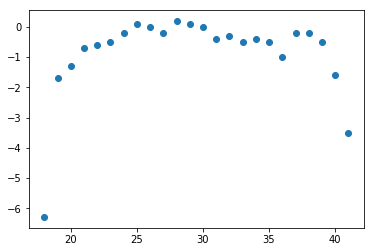

In [125]:
plt.scatter(np.sort(a.Age.unique()), a.groupby(a.Age)['OBPM'].quantile(.50))

In [119]:
a.Age.unique().sort()

In [120]:
a.Age.unique().sort()

array([32, 24, 21, 26, 29, 27, 25, 28, 22, 23, 30, 31, 33, 20, 34, 19, 35,
       36, 37, 38, 39, 40, 41, 18])

In [117]:
a.groupby(a.Age)['OBPM'].quantile(.75)

Age
18   -6.300
19   -0.600
20    0.000
21    0.500
22    0.600
23    1.000
24    1.000
25    1.500
26    1.400
27    1.225
28    1.700
29    1.200
30    1.300
31    0.900
32    0.900
33    0.700
34    0.825
35    0.300
36    1.400
37    1.100
38    0.800
39    0.050
40   -0.500
41   -3.500
Name: OBPM, dtype: float64

In [150]:
test = "Rudy Gobert, Utah, 54 (5); LeBron James, Cleveland, 47 (6); Russell Westbrook, Oklahoma City, 35 (13); Avery Bradley, Boston, 26 (5); Michael Kidd-Gilchrist, Charlotte, 21 (2); Klay Thompson, Golden State, 19 (3); Marc Gasol, Memphis, 18 (2); Danny Green, San Antonio, 18; Trevor Ariza, Houston, 17 (1); Stephen Curry, Golden State, 14 (2); DeMarre Carroll, Atlanta, 11 (1); Patrick Beverley, Houston, 10 (1); Khris Middleton, Milwaukee, 9 (1); Serge Ibaka, Oklahoma City, 8; Andre Iguodala, Golden State, 8; Paul Millsap, Atlanta, 8; Jeff Teague, Atlanta, 7 (1); Mike Conley, Memphis, 6 (2); Joakim Noah, Chicago, 6; Nerlens Noel, Philadelphia, 5 (1); P.J. Tucker, Phoenix, 4; Giannis Antetokounmpo, Milwaukee, 3; Pau Gasol, Chicago, 3; Wesley Matthews, Portland, 3; James Harden, Houston, 2; Marcus Smart, Boston, 2; Hassan Whiteside, Miami, 2 (1); Eric Bledsoe, Phoenix, 1; DeMarcus Cousins, Sacramento, 1; Andre Drummond, Detroit, 1; Manu Ginobili, San Antonio, 1; Blake Griffin, L.A. Clippers, 1; George Hill, Indiana, 1; Al Horford, Atlanta, 1; Victor Oladipo, Orlando, 1; Zaza Pachulia, Milwaukee, 1; Elfrid Payton, Orlando, 1; Zach Randolph, Memphis, 1; Rajon Rondo, Dallas, 1; Iman Shumpert, Cleveland, 1; Dwyane Wade, Miami, 1"

In [164]:
def text_to_votes(test):
    tl = test.split(";")
    tl = [i.split(",") for i in tl]
    tldict = {i[0]: int(i[2].split()[0]) for i in tl}
    return tldict

In [151]:
tl = test.split(";")

In [152]:
tl = [i.split(",") for i in tl]
    

In [158]:
tldict = {i[0]: int(i[2].split()[0]) for i in tl}

In [171]:
defvotes15 = tldict

In [148]:
tl2 = [i[2].split()[0] for i in tl2]

In [149]:
tl2

['54',
 '47',
 '35',
 '26',
 '21',
 '19',
 '18',
 '18',
 '17',
 '14',
 '11',
 '10',
 '9',
 '8',
 '8',
 '8',
 '7',
 '6',
 '6',
 '5',
 '4',
 '3',
 '3',
 '3',
 '2',
 '2',
 '2',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1',
 '1']

In [141]:
tdict = {i[1], i[3].}

[['Rudy Gobert', ' Utah', ' 54 (5)'],
 [' LeBron James', ' Cleveland', ' 47 (6)'],
 [' Russell Westbrook', ' Oklahoma City', ' 35 (13)'],
 [' Avery Bradley', ' Boston', ' 26 (5)'],
 [' Michael Kidd-Gilchrist', ' Charlotte', ' 21 (2)'],
 [' Klay Thompson', ' Golden State', ' 19 (3)'],
 [' Marc Gasol', ' Memphis', ' 18 (2)'],
 [' Danny Green', ' San Antonio', ' 18'],
 [' Trevor Ariza', ' Houston', ' 17 (1)'],
 [' Stephen Curry', ' Golden State', ' 14 (2)'],
 [' DeMarre Carroll', ' Atlanta', ' 11 (1)'],
 [' Patrick Beverley', ' Houston', ' 10 (1)'],
 [' Khris Middleton', ' Milwaukee', ' 9 (1)'],
 [' Serge Ibaka', ' Oklahoma City', ' 8'],
 [' Andre Iguodala', ' Golden State', ' 8'],
 [' Paul Millsap', ' Atlanta', ' 8'],
 [' Jeff Teague', ' Atlanta', ' 7 (1)'],
 [' Mike Conley', ' Memphis', ' 6 (2)'],
 [' Joakim Noah', ' Chicago', ' 6'],
 [' Nerlens Noel', ' Philadelphia', ' 5 (1)'],
 [' P.J. Tucker', ' Phoenix', ' 4'],
 [' Giannis Antetokounmpo', ' Milwaukee', ' 3'],
 [' Pau Gasol', ' Chic

In [168]:
def2104 = "DeAndre Jordan, L.A. Clippers, 63 (14); Anthony Davis, New Orleans, 62 (18); Tony Allen, Memphis, 60 (17); Tim Duncan, San Antonio, 45 (12); Dwight Howard, Houston, 26 (6); Taj Gibson, Chicago, 21 (2); Mike Conley, Memphis, 21 (5); Ricky Rubio, Minnesota, 19 (5); Lance Stephenson, Indiana, 14 (3); P.J. Tucker, Phoenix, 13 (2); Kevin Durant, Oklahoma City, 10 (2); Kyle Lowry, Toronto, 10 (3); Eric Bledsoe, Phoenix, 9 (1); Marc Gasol, Memphis, 8; John Wall, Washington, 8 (1); Thabo Sefolosha, Oklahoma City, 8 (1); Kirk Hinrich, Chicago, 7 (2); Trevor Ariza, Washington, 5 (2); Avery Bradley, Boston, 5 (1); Russell Westbrook, Oklahoma City, 5 (1); Klay Thompson, Golden State, 5; Andrew Bogut, Golden State, 4; Chris Bosh, Miami, 4 (1); Luol Deng, Cleveland, 4 (1); Wesley Matthews, Portland, 4 (1); Tony Parker, San Antonio, 4 (1); Nicolas Batum, Portland, 3 (1); Stephen Curry, Golden State, 3 (1); Danny Green, San Antonio, 3 (1); Michael Kidd-Gilchrist, Charlotte, 3; Shaun Livingston, Brooklyn, 3 (1); Victor Oladipo, Orlando, 3 (1); DeMarre Carroll, Atlanta, 2; Matt Barnes, L.A. Clippers, 2 (1); James Harden, Houston, 2; George Hill, Indiana, 2; Jeff Teague, Atlanta, 2; Dwyane Wade, Miami, 2 (1); Kemba Walker, Charlotte, 2; David West, Indiana, 2; Arron Afflalo, Orlando, 1; Corey Brewer, Minnesota, 1; Michael Carter-Williams, Philadelphia,1; Darren Collison, L.A. Clippers, 1; DeMar DeRozan, Toronto, 1; Andre Drummond, Detroit, 1; Monta Ellis, Dallas, 1; Danny Granger, L.A. Clippers, 1; Draymond Green, Golden State, 1; Reggie Jackson, Oklahoma City, 1; David Lee, Golden State, 1; Paul Millsap, Atlanta, 1; Rajon Rondo, Boston, 1"

In [169]:
defvotes14 = text_to_votes(def2104)

In [170]:
defvotes14

{'DeAndre Jordan': 63,
 ' Anthony Davis': 62,
 ' Tony Allen': 60,
 ' Tim Duncan': 45,
 ' Dwight Howard': 26,
 ' Taj Gibson': 21,
 ' Mike Conley': 21,
 ' Ricky Rubio': 19,
 ' Lance Stephenson': 14,
 ' P.J. Tucker': 13,
 ' Kevin Durant': 10,
 ' Kyle Lowry': 10,
 ' Eric Bledsoe': 9,
 ' Marc Gasol': 8,
 ' John Wall': 8,
 ' Thabo Sefolosha': 8,
 ' Kirk Hinrich': 7,
 ' Trevor Ariza': 5,
 ' Avery Bradley': 5,
 ' Russell Westbrook': 5,
 ' Klay Thompson': 5,
 ' Andrew Bogut': 4,
 ' Chris Bosh': 4,
 ' Luol Deng': 4,
 ' Wesley Matthews': 4,
 ' Tony Parker': 4,
 ' Nicolas Batum': 3,
 ' Stephen Curry': 3,
 ' Danny Green': 3,
 ' Michael Kidd-Gilchrist': 3,
 ' Shaun Livingston': 3,
 ' Victor Oladipo': 3,
 ' DeMarre Carroll': 2,
 ' Matt Barnes': 2,
 ' James Harden': 2,
 ' George Hill': 2,
 ' Jeff Teague': 2,
 ' Dwyane Wade': 2,
 ' Kemba Walker': 2,
 ' David West': 2,
 ' Arron Afflalo': 1,
 ' Corey Brewer': 1,
 ' Michael Carter-Williams': 1,
 ' Darren Collison': 1,
 ' DeMar DeRozan': 1,
 ' Andre Drummo

In [172]:
lofd = [defvotes15,defvotes14]

[{'Rudy Gobert': 54,
  ' LeBron James': 47,
  ' Russell Westbrook': 35,
  ' Avery Bradley': 26,
  ' Michael Kidd-Gilchrist': 21,
  ' Klay Thompson': 19,
  ' Marc Gasol': 18,
  ' Danny Green': 18,
  ' Trevor Ariza': 17,
  ' Stephen Curry': 14,
  ' DeMarre Carroll': 11,
  ' Patrick Beverley': 10,
  ' Khris Middleton': 9,
  ' Serge Ibaka': 8,
  ' Andre Iguodala': 8,
  ' Paul Millsap': 8,
  ' Jeff Teague': 7,
  ' Mike Conley': 6,
  ' Joakim Noah': 6,
  ' Nerlens Noel': 5,
  ' P.J. Tucker': 4,
  ' Giannis Antetokounmpo': 3,
  ' Pau Gasol': 3,
  ' Wesley Matthews': 3,
  ' James Harden': 2,
  ' Marcus Smart': 2,
  ' Hassan Whiteside': 2,
  ' Eric Bledsoe': 1,
  ' DeMarcus Cousins': 1,
  ' Andre Drummond': 1,
  ' Manu Ginobili': 1,
  ' Blake Griffin': 1,
  ' George Hill': 1,
  ' Al Horford': 1,
  ' Victor Oladipo': 1,
  ' Zaza Pachulia': 1,
  ' Elfrid Payton': 1,
  ' Zach Randolph': 1,
  ' Rajon Rondo': 1,
  ' Iman Shumpert': 1,
  ' Dwyane Wade': 1},
 {'DeAndre Jordan': 63,
  ' Anthony Davis':

In [174]:
both = {15: defvotes15, 14:defvotes14}

In [180]:
for k, v in defvotes15.items():
    defvotes15[k] = defvotes15[k]/3

In [182]:
for k, v in defvotes14.items():
    defvotes14[k] = defvotes14[k]/3

In [183]:
defvotes14

{'DeAndre Jordan': 21.0,
 ' Anthony Davis': 20.666666666666668,
 ' Tony Allen': 20.0,
 ' Tim Duncan': 15.0,
 ' Dwight Howard': 8.666666666666666,
 ' Taj Gibson': 7.0,
 ' Mike Conley': 7.0,
 ' Ricky Rubio': 6.333333333333333,
 ' Lance Stephenson': 4.666666666666667,
 ' P.J. Tucker': 4.333333333333333,
 ' Kevin Durant': 3.3333333333333335,
 ' Kyle Lowry': 3.3333333333333335,
 ' Eric Bledsoe': 3.0,
 ' Marc Gasol': 2.6666666666666665,
 ' John Wall': 2.6666666666666665,
 ' Thabo Sefolosha': 2.6666666666666665,
 ' Kirk Hinrich': 2.3333333333333335,
 ' Trevor Ariza': 1.6666666666666667,
 ' Avery Bradley': 1.6666666666666667,
 ' Russell Westbrook': 1.6666666666666667,
 ' Klay Thompson': 1.6666666666666667,
 ' Andrew Bogut': 1.3333333333333333,
 ' Chris Bosh': 1.3333333333333333,
 ' Luol Deng': 1.3333333333333333,
 ' Wesley Matthews': 1.3333333333333333,
 ' Tony Parker': 1.3333333333333333,
 ' Nicolas Batum': 1.0,
 ' Stephen Curry': 1.0,
 ' Danny Green': 1.0,
 ' Michael Kidd-Gilchrist': 1.0,
 '

In [176]:
v13 = "Andre Iguodala, Philadelphia, 19 (4); Joakim Noah, Chicago, 14; Iman Shumpert, New York, 13 (4); Paul George, Indiana, 10 (2); Russell Westbrook, Oklahoma City, 9 (2); Josh Smith, Atlanta, 8 (2); Dwyane Wade, Miami, 5 (1); Thabo Sefolosha, Oklahoma City, 5 (1); Grant Hill, Phoenix, 5 (1); Tim Duncan, San Antonio, 5 (1); Avery Bradley, Boston, 3 (1); Marc Gasol, Memphis, 3 (1); Metta World Peace, L.A. Lakers, 3; Shawn Marion, Dallas, 3; Joe Johnson, Atlanta, 2, (1); Mike Conley, Memphis, 2; Derrick Rose, Chicago, 1; Jrue Holiday, Philadelphia, 1; Carlos Boozer, Chicago, 1; Luc Mbah a Moute, Milwaukee, 1"

In [177]:
defvotes13 = text_to_votes(v13)

In [178]:
defvotes13

{'Andre Iguodala': 19,
 ' Joakim Noah': 14,
 ' Iman Shumpert': 13,
 ' Paul George': 10,
 ' Russell Westbrook': 9,
 ' Josh Smith': 8,
 ' Dwyane Wade': 5,
 ' Thabo Sefolosha': 5,
 ' Grant Hill': 5,
 ' Tim Duncan': 5,
 ' Avery Bradley': 3,
 ' Marc Gasol': 3,
 ' Metta World Peace': 3,
 ' Shawn Marion': 3,
 ' Joe Johnson': 2,
 ' Mike Conley': 2,
 ' Derrick Rose': 1,
 ' Jrue Holiday': 1,
 ' Carlos Boozer': 1,
 ' Luc Mbah a Moute': 1}

In [185]:
all3 = {13: defvotes13, 14: defvotes14, 15:defvotes15}

In [193]:
for k, v in all3.items():
    start = 13
    while k-start > 0:
        for player, votes in all3[k]:
            if player in all3[start].keys():
                all3[k][player] += all3[start][player]
            start += 1

ValueError: too many values to unpack (expected 2)

TypeError: unhashable type: 'slice'